# Fit the target data model for scatter

This notebook demonstrates how the target data model for scatter in halo concentration was fit

In [2]:
import matplotlib.cm as cm
from time import time
from matplotlib import lines as mlines

In [3]:
import os
from astropy.table import Table
diffprof_drn = "/Users/aphearin/work/DATA/diffprof_data"
mdpl2 = Table.read(os.path.join(diffprof_drn, "MDPL2_halo_table.hdf5"))
bpl = Table.read(os.path.join(diffprof_drn, "BPL_halo_table.hdf5"))
print(bpl.keys())

['halo_id', 'conc_beta_early', 'conc_beta_late', 'conc_k', 'conc_lgtc', 'u_conc_beta_early', 'u_conc_beta_late', 'u_conc_k', 'u_conc_lgtc', 'logmp', 'mah_early', 'mah_late', 'mah_logtc', 'mah_k', 'log_mah_fit', 'conch_fit', 'tform_50', 'p_tform_50']


In [4]:
from diffprof.nfw_evolution import lgc_vs_lgt

lgc_vs_lgt_vmap = jjit(jvmap(lgc_vs_lgt, in_axes=(None, 0, 0, 0, 0)))

N_T = 25
TARR_FIT = np.linspace(3.5, 13, N_T)

lgconc_history_bpl = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), bpl["conc_lgtc"], bpl["conc_k"], bpl["conc_beta_early"], bpl["conc_beta_late"]))
lgconc_history_mdpl2 = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), mdpl2["conc_lgtc"], mdpl2["conc_k"], mdpl2["conc_beta_early"], mdpl2["conc_beta_late"]))


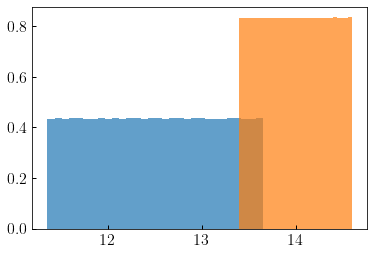

In [5]:
from diffprof.latin_hypercube import get_scipy_kdtree, retrieve_lh_sample_indices
tree_bpl = get_scipy_kdtree(bpl['logmp'])
tree_mdpl2 = get_scipy_kdtree(mdpl2['logmp'])

indx_bpl = retrieve_lh_sample_indices(tree_bpl, 11.35, 13.65, 1, 100_000)
indx_mdpl2 = retrieve_lh_sample_indices(tree_mdpl2, 13.4, 14.6, 1, 100_000)

fig, ax = plt.subplots(1, 1)
__=ax.hist(bpl['logmp'][indx_bpl], bins=30, density=True, alpha=0.7)
__=ax.hist(mdpl2['logmp'][indx_mdpl2], bins=30, density=True, alpha=0.7)


In [6]:
from diffprof.get_target_simdata import target_data_generator

N_MH_TARGETS, N_P_TARGETS = 20, 15

args = (bpl['logmp'][indx_bpl],
    mdpl2['logmp'][indx_mdpl2],
    lgconc_history_bpl[indx_bpl],
    lgconc_history_mdpl2[indx_mdpl2],
    bpl['p_tform_50'][indx_bpl],
    mdpl2['p_tform_50'][indx_mdpl2],
    N_MH_TARGETS,
    N_P_TARGETS
       )
gen = target_data_generator(*args)
target_data = next(gen)
lgmhalo_targets, p50_targets = target_data[0:2]
lgc_mean_targets_lgm0, lgc_std_targets_lgm0 = target_data[2:4]
lgc_mean_targets_lgm0_p50, lgc_std_targets_lgm0_p50 = target_data[4:]


Runtime to generate target data = 5.1 seconds


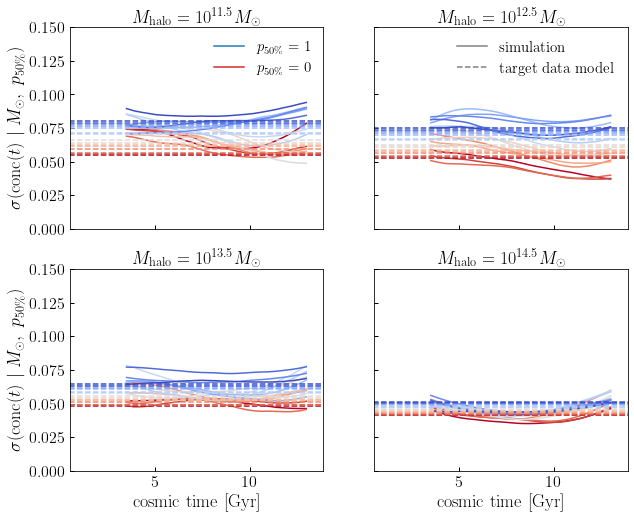

In [7]:
from diffprof.target_data_model.diffconc_std_p50_model import _scatter_vs_p50_and_lgmhalo
from diffprof.target_data_model.diffconc_std_p50_model import PARAMS as P50_SIG_PARAMS

start = time()
target_data = next(gen)
lgmhalo_targets, p50_targets = target_data[0:2]
lgc_mean_targets_lgm0, lgc_std_targets_lgm0 = target_data[2:4]
lgc_mean_targets_lgm0_p50, lgc_std_targets_lgm0_p50 = target_data[4:]
end = time()
print("Runtime to generate target data = {0:.1f} seconds".format(end-start))

p50_colors=cm.coolwarm(np.linspace(1, 0, N_P_TARGETS))

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
xlim = ax0.set_xlim(0.5, 13.9)
ylim = ax0.set_ylim(0, 0.15)
axes = ax0, ax1, ax2, ax3

red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$p_{50\%}=0$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$p_{50\%}=1$')

for ax, lgm in zip(axes, (11.5, 12.5, 13.5, 14.5)):
    im = np.argmin(np.abs(lgmhalo_targets - lgm))
    for ip, p50 in enumerate(p50_targets):
        __=ax.plot(TARR_FIT, lgc_std_targets_lgm0_p50[im, ip, :], color=p50_colors[ip])

for ax in ax2, ax3:
    xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
for ax in ax0, ax2:
    ylabel = ax.set_ylabel(r'$\sigma({\rm conc}(t)\ \vert\ M_{\odot},\ p_{50\%})$')

titles = (r'$M_{\rm halo}=10^{11.5}M_{\odot}$',r'$M_{\rm halo}=10^{12.5}M_{\odot}$',
       r'$M_{\rm halo}=10^{13.5}M_{\odot}$', r'$M_{\rm halo}=10^{14.5}M_{\odot}$')
for ax, title in zip(axes, titles):
    __=ax.set_title(title)

tarr_plot = np.linspace(-100, 100, 5000)
for ax, lgm in zip(axes, (11.5, 12.5, 13.5, 14.5)):
    for ip, p50 in enumerate(p50_targets):
        scatter = _scatter_vs_p50_and_lgmhalo(lgm, p50, *P50_SIG_PARAMS.values())
        __=ax.plot(tarr_plot, np.zeros_like(tarr_plot)+scatter, '--', color=p50_colors[ip])

from matplotlib import lines as mlines
red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$p_{50\%}=0$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$p_{50\%}=1$')
solid_line=mlines.Line2D([],[],ls='-',c='gray',label=r'${\rm simulation}$')
dashed_line=mlines.Line2D([],[],ls='--',c='gray',label=r'${\rm target\ data\ model}$')

leg=ax0.legend(handles=[blue_line, red_line])
leg=ax1.legend(handles=[solid_line, dashed_line])

fig.savefig('std_p50_target_data_model_init.png', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)

In [8]:
@jjit
def _get_all_params_from_varied_params(varied_params):
    default_params = jnp.array(list(P50_SIG_PARAMS.values()))
    p50_sig_x0, p50_sig_k = default_params[:2]
    (
        p50_sig_plo_x0,
        p50_sig_plo_k,
        p50_sig_plo_ylo,
        p50_sig_plo_yhi,
    ) = default_params[2:6]
    (
        p50_sig_width_x0,
        p50_sig_width_k,
        p50_sig_width_lgylo,
        p50_sig_width_lgyhi,
    ) = default_params[6:]

    (
        p50_sig_plo_x0,
        p50_sig_plo_ylo,
        p50_sig_plo_yhi,
        p50_sig_width_x0,
        p50_sig_width_lgylo,
        p50_sig_width_lgyhi,
    ) = varied_params

    all_params = (
        p50_sig_x0,
        p50_sig_k,
        p50_sig_plo_x0,
        p50_sig_plo_k,
        p50_sig_plo_ylo,
        p50_sig_plo_yhi,
        p50_sig_width_x0,
        p50_sig_width_k,
        p50_sig_width_lgylo,
        p50_sig_width_lgyhi,
    )
    return all_params


In [9]:
DEFAULT_P50_SIG_PARAMS = jnp.array(list(P50_SIG_PARAMS.values()))

n_pars = len(P50_SIG_PARAMS)
_a = [0, None, *[None]*n_pars]
_b = [None, 0, *[None]*n_pars]
_scatter_vs_p50_and_lgmhalo_vmap = jjit(
    jvmap(jvmap(_scatter_vs_p50_and_lgmhalo, in_axes=_b), in_axes=_a))

@jjit
def _mse(pred, target):
    diff = pred - target
    return jnp.mean(diff * diff)


@jjit
def _loss_all_targets(varied_pars, data):
    lgmh_targets, p_targets, lgc_std_targets = data
    all_pars = _get_all_params_from_varied_params(varied_pars)
    lgc_std_constant = _scatter_vs_p50_and_lgmhalo_vmap(lgmh_targets, p_targets, *all_pars)
    lgc_std_pred = lgc_std_constant.reshape((*lgc_std_constant.shape, 1))
    return _mse(lgc_std_pred, lgc_std_targets)
    
    

In [10]:
varied_param_names = ('p50_sig_plo_x0', 'p50_sig_plo_ylo','p50_sig_plo_yhi', 
                      'p50_sig_width_x0', 'p50_sig_width_lgylo', 'p50_sig_width_lgyhi')
p0 = jnp.array([P50_SIG_PARAMS[key] for key in varied_param_names])
varied_p_best = p0

In [11]:
from diffprof.fitting_helpers import jax_adam_wrapper

n_steps_per_epoch = 500
n_epochs = 5
epoch_collector = []
epoch_collector2 = []
for iepoch in range(n_epochs):
    print("...measuring target data for epoch {0}".format(iepoch+1))
    target_data = next(gen)
    lgmhalo_targets, p50_targets = target_data[0:2]
    lgc_std_targets_lgm0_p50 = target_data[-1]
    loss_data = lgmhalo_targets, p50_targets, lgc_std_targets_lgm0_p50

    print("...fitting target data model for epoch {0}\n".format(iepoch+1))
    res = jax_adam_wrapper(
        _loss_all_targets, varied_p_best, loss_data, n_steps_per_epoch, 
        step_size=0.001, n_warmup=0)
    varied_p_best, loss_min, loss_history = res[:3]
    p_best = _get_all_params_from_varied_params(varied_p_best)
    epoch_collector.extend(loss_history)
    epoch_collector2.append(loss_history)


...measuring target data for epoch 1
...fitting target data model for epoch 1

...measuring target data for epoch 2
...fitting target data model for epoch 2

...measuring target data for epoch 3
...fitting target data model for epoch 3

...measuring target data for epoch 4
...fitting target data model for epoch 4

...measuring target data for epoch 5
...fitting target data model for epoch 5



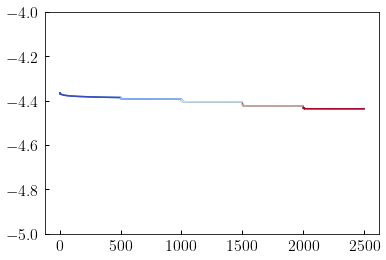

In [12]:
step_arr = np.arange(1, n_steps_per_epoch*n_epochs+1).reshape((n_epochs, n_steps_per_epoch))
p50_colors=cm.coolwarm(np.linspace(0, 1, n_epochs))

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(-5, -4)
__=ax.plot(step_arr.flatten(), np.log10(epoch_collector))
for epoch, color in enumerate(p50_colors):
    __=ax.plot(step_arr[epoch, :], np.log10(epoch_collector2[epoch]), color=color)
    

Runtime to generate target data = 5.0 seconds


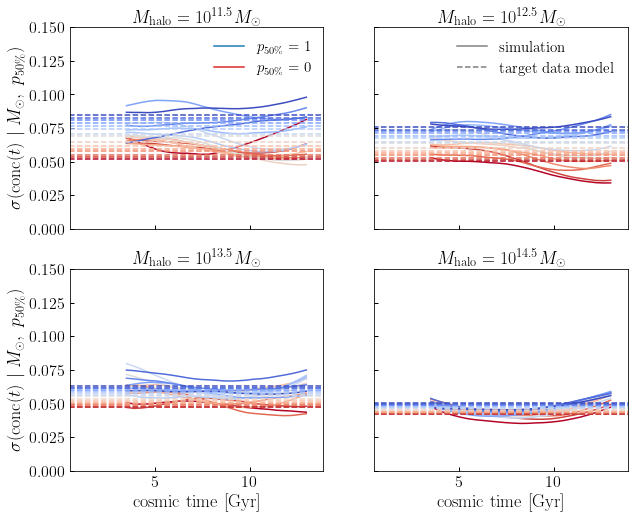

In [13]:
from diffprof.target_data_model.diffconc_std_p50_model import _scatter_vs_p50_and_lgmhalo
from diffprof.target_data_model.diffconc_std_p50_model import PARAMS as P50_SIG_PARAMS

start = time()
target_data = next(gen)
lgmhalo_targets, p50_targets = target_data[0:2]
lgc_mean_targets_lgm0, lgc_std_targets_lgm0 = target_data[2:4]
lgc_mean_targets_lgm0_p50, lgc_std_targets_lgm0_p50 = target_data[4:]
end = time()
print("Runtime to generate target data = {0:.1f} seconds".format(end-start))

p50_colors=cm.coolwarm(np.linspace(1, 0, N_P_TARGETS))

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
xlim = ax0.set_xlim(0.5, 13.9)
ylim = ax0.set_ylim(0, 0.15)
axes = ax0, ax1, ax2, ax3

red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$p_{50\%}=0$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$p_{50\%}=1$')

for ax, lgm in zip(axes, (11.5, 12.5, 13.5, 14.5)):
    im = np.argmin(np.abs(lgmhalo_targets - lgm))
    for ip, p50 in enumerate(p50_targets):
        __=ax.plot(TARR_FIT, lgc_std_targets_lgm0_p50[im, ip, :], color=p50_colors[ip])

for ax in ax2, ax3:
    xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
for ax in ax0, ax2:
    ylabel = ax.set_ylabel(r'$\sigma({\rm conc}(t)\ \vert\ M_{\odot},\ p_{50\%})$')

titles = (r'$M_{\rm halo}=10^{11.5}M_{\odot}$',r'$M_{\rm halo}=10^{12.5}M_{\odot}$',
       r'$M_{\rm halo}=10^{13.5}M_{\odot}$', r'$M_{\rm halo}=10^{14.5}M_{\odot}$')
for ax, title in zip(axes, titles):
    __=ax.set_title(title)

tarr_plot = np.linspace(-100, 100, 5000)
for ax, lgm in zip(axes, (11.5, 12.5, 13.5, 14.5)):
    for ip, p50 in enumerate(p50_targets):
        scatter = _scatter_vs_p50_and_lgmhalo(lgm, p50, *p_best)
        __=ax.plot(tarr_plot, np.zeros_like(tarr_plot)+scatter, '--', color=p50_colors[ip])

from matplotlib import lines as mlines
red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$p_{50\%}=0$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$p_{50\%}=1$')
solid_line=mlines.Line2D([],[],ls='-',c='gray',label=r'${\rm simulation}$')
dashed_line=mlines.Line2D([],[],ls='--',c='gray',label=r'${\rm target\ data\ model}$')

leg=ax0.legend(handles=[blue_line, red_line])
leg=ax1.legend(handles=[solid_line, dashed_line])

fig.savefig('std_p50_target_data_model_fit.png', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)

In [16]:
from collections import OrderedDict
d_best = OrderedDict([(key, val) for key, val in zip(P50_SIG_PARAMS.keys(), p_best)])

for key, val in d_best.items():
    print("{0}={1:.3f},".format(key, val))

p50_sig_x0=0.500,
p50_sig_k=5.000,
p50_sig_plo_x0=15.202,
p50_sig_plo_k=1.000,
p50_sig_plo_ylo=0.048,
p50_sig_plo_yhi=0.027,
p50_sig_width_x0=13.142,
p50_sig_width_k=1.000,
p50_sig_width_lgylo=-1.314,
p50_sig_width_lgyhi=-4.333,
